##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Download This Template from Google Colab, and then make a copy in your own Google Drive and Edit. You may need a Google Account for your Google Drive and Colab. 
https://colab.research.google.com/drive/1cInaFPxjhQIsOZo2VyGDpMeWFSPXmttl?usp=sharing


# **Time series forecasting**

This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

### Setup Environment

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

## The weather dataset
This tutorial uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max-Planck-Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/index.php/Main/HomePage).

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [3]:
# store csv as dataframe
df = pd.read_csv('weather.csv') # load the Google Storage data as a pandas dataframe

Let's take a glance at the data.

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [5]:
df.shape

(70091, 15)

As you can see above, an observation is recorded every 1 hour. This means that, for a single hour, you will have 1 observations. Similarly, a single day will contain 24 (1x24) observations. 

Given a specific time, let's say you want to** predict the temperature 6 hours **in the future. In order to make this prediction, you choose to **use 5 days of observations**. Thus, you would create a window containing the last 120(5x24) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In both the following tutorials, the first 50,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [7]:
TRAIN_SPLIT = 50000

Setting seed to ensure reproducibility.

In [8]:
tf.random.set_seed(13)

## **Part 1: Forecast a univariate time series**
First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

Date Time
01.01.2009 01:00:00   -8.05
01.01.2009 02:00:00   -8.88
01.01.2009 03:00:00   -8.81
01.01.2009 04:00:00   -9.05
01.01.2009 05:00:00   -9.63
Name: T (degC), dtype: float64


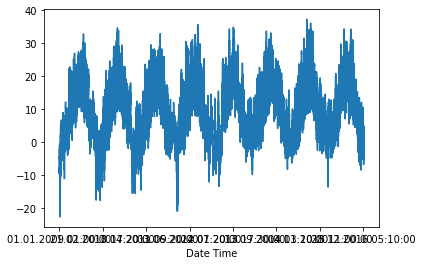

In [9]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
print(uni_data.head())
uni_data.plot()
uni_data = uni_data.values


It is important to normalize features before training a neural network. A common way to do so is by subtracting the mean and dividing by the standard deviation of each feature.

Note: The mean and standard deviation should only be computed using the training data.

In [10]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's normalize the data.

In [11]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 24 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [12]:
univariate_past_history = 24
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [13]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-2.0011344 ]
 [-2.0972334 ]
 [-2.08912866]
 [-2.11691633]
 [-2.18406985]
 [-2.18870112]
 [-2.13081016]
 [-2.0069235 ]
 [-1.95597945]
 [-1.88419465]
 [-1.92703396]
 [-1.86451172]
 [-1.75104543]
 [-1.75683453]
 [-1.72788905]
 [-1.69431229]
 [-1.69083883]
 [-1.676945  ]
 [-1.66073553]
 [-1.63642132]
 [-1.62484313]
 [-1.59010855]
 [-1.58663509]
 [-1.59473983]]

 Target temperature to predict
-1.5831616366560513


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [14]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0]-1, (future+2)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

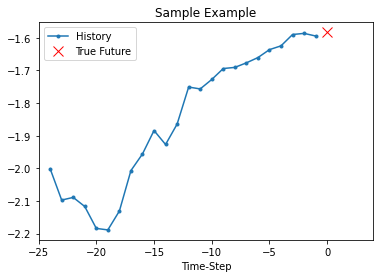

In [15]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### 1.1 Baseline Model
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 24 observations.

In [16]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

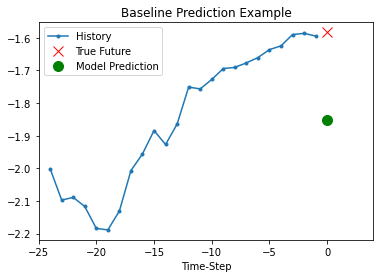

In [17]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### 1.2 Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [18]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

You will see the LSTM requires the input shape of the data it is being given.

In [19]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [20]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 1s 3ms/step
(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 100 steps, instead of the complete training data as normally done.

In [21]:
EVALUATION_INTERVAL = 100
EPOCHS = 5

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/5
100/100 [==============================] - 5s 18ms/step - loss: 0.8357 - val_loss: 0.4723
Epoch 2/5
100/100 [==============================] - 1s 13ms/step - loss: 0.3837 - val_loss: 0.2687
Epoch 3/5
100/100 [==============================] - 1s 13ms/step - loss: 0.2675 - val_loss: 0.2023
Epoch 4/5
100/100 [==============================] - 1s 10ms/step - loss: 0.1876 - val_loss: 0.1509
Epoch 5/5
100/100 [==============================] - 1s 11ms/step - loss: 0.1446 - val_loss: 0.1150


#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

8/8 [==============================] - 0s 6ms/step


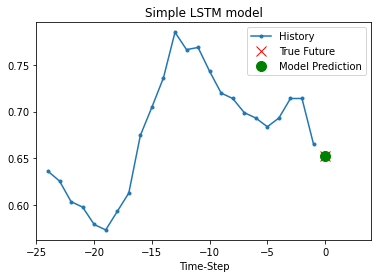

8/8 [==============================] - 0s 4ms/step


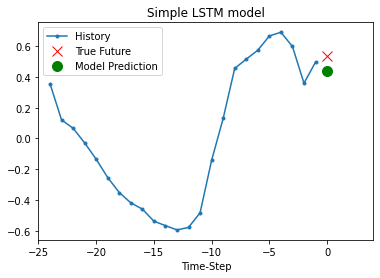

8/8 [==============================] - 0s 6ms/step


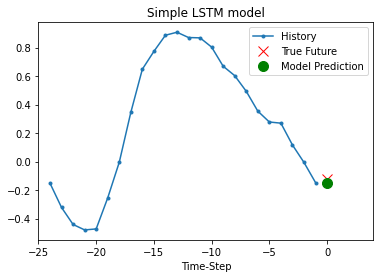

In [22]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## **Part 2: Forecast a multivariate time series**

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [23]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [24]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 01:00:00,996.50,-8.05,1307.86
01.01.2009 02:00:00,996.62,-8.88,1312.25
01.01.2009 03:00:00,996.84,-8.81,1312.18
01.01.2009 04:00:00,996.99,-9.05,1313.61
01.01.2009 05:00:00,997.46,-9.63,1317.19


Let's have a look at how each of these features vary across time.

array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

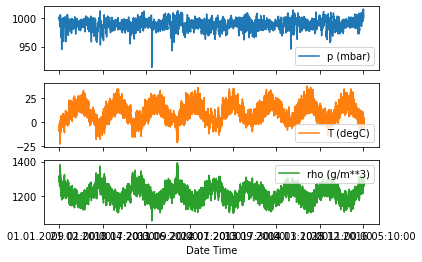

In [25]:
features.plot(subplots=True)

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [26]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [27]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [28]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 120 observations that are sampled every hour. For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 12 observations is used.

In [29]:
past_history = 120
future_target = 12
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [30]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [31]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [32]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [33]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 [==============================] - 1s 5ms/step
(256, 1)


In [34]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/5
100/100 [==============================] - 5s 15ms/step - loss: 0.4005 - val_loss: 0.3043
Epoch 2/5
100/100 [==============================] - 1s 10ms/step - loss: 0.2786 - val_loss: 0.2896
Epoch 3/5
100/100 [==============================] - 1s 9ms/step - loss: 0.2774 - val_loss: 0.2798
Epoch 4/5
100/100 [==============================] - 1s 10ms/step - loss: 0.2589 - val_loss: 0.2776
Epoch 5/5
100/100 [==============================] - 1s 9ms/step - loss: 0.2637 - val_loss: 0.2741


#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

8/8 [==============================] - 0s 4ms/step


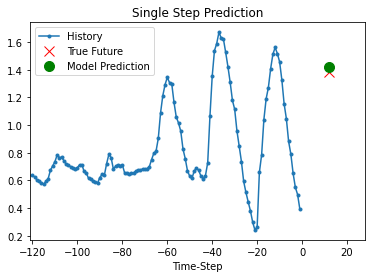

8/8 [==============================] - 0s 4ms/step


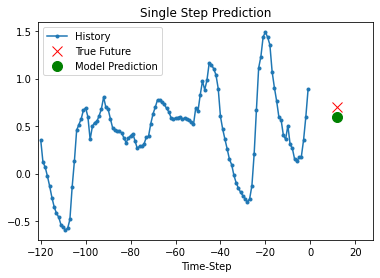

In [35]:
for x, y in val_data_single.take(2):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. The output is 12 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [36]:
future_target = 12
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [37]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (12,)


In [38]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [39]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

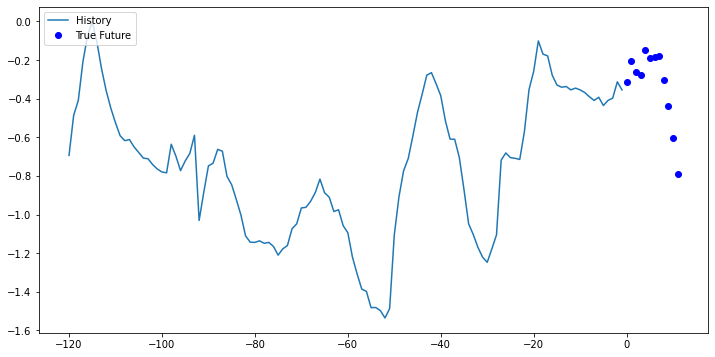

In [40]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [41]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(12))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [42]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 [==============================] - 1s 20ms/step
(256, 12)


In [43]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/5
100/100 [==============================] - 28s 250ms/step - loss: 0.4693 - val_loss: 0.3455
Epoch 2/5
100/100 [==============================] - 25s 246ms/step - loss: 0.3479 - val_loss: 0.3314
Epoch 3/5
100/100 [==============================] - 24s 245ms/step - loss: 0.3506 - val_loss: 0.3244
Epoch 4/5
100/100 [==============================] - 28s 280ms/step - loss: 0.3134 - val_loss: 0.2929
Epoch 5/5
100/100 [==============================] - 26s 260ms/step - loss: 0.2751 - val_loss: 0.2690


#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

8/8 [==============================] - 0s 20ms/step


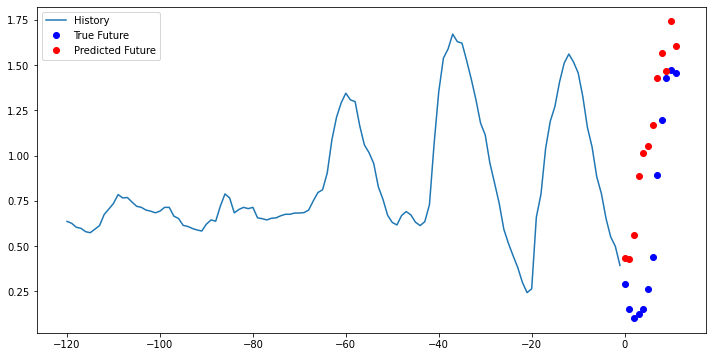

8/8 [==============================] - 0s 23ms/step


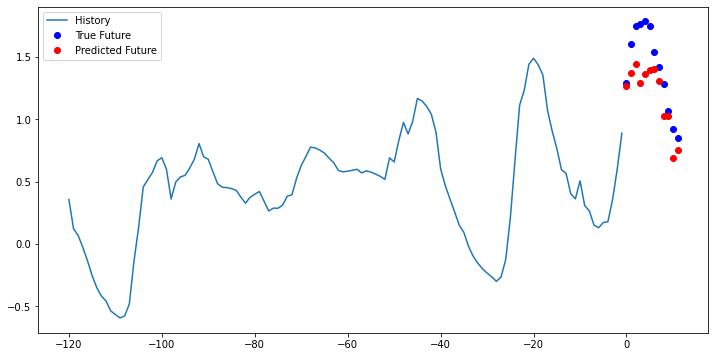

In [44]:
for x, y in val_data_multi.take(2):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## Next steps
This tutorial was a quick introduction to time series forecasting using an RNN. You may now try to predict the stock market and become a billionaire.

For further understanding, you may read Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition and Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).